In [1]:
import numpy as np

from forex.pre_training_data_prep.config import config
from forex.pre_training_data_prep.DataPrepTimeseries import DataPrepTimeseries
from forex.post_training.ModelResult import ModelResult

2025-03-21 17:50:01.917782: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 17:50:01.950018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-21 17:50:01.950061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-21 17:50:01.950842: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 17:50:01.956213: I tensorflow/core/platform/cpu_feature_guar

In [12]:
filename_train_val_test_dict = '/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/forecasting/deep_learning/forex/output/n_back_equals_180/dict_final_numpy.pickled'

application_root_directory = '/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/forecasting/deep_learning'
model_training_output_directory = application_root_directory + '/output'

#training_run = 'blah----d2707bf6-0b59-44ae-acaf-bfbe32276743'  # 1.1213096426769333  ## mean, three hours back
#training_run = 'blah----8eda54d5-45dd-4a99-8651-bc797c950bd7' # 1.3892486610454655  ## mean, three hours back, lighter overfitting protection
#training_run = 'blah----c71d821d-8b59-4500-8d51-fd90bf90aec4'  # 1.1255950721940127
# training_run = 'blah----2bf0a932-921f-43ce-8d36-f2c023afdc3e' # 1.1224698543134826
training_run = 'blah----52f8b9c1-bf1c-49c3-a8d8-b599d6feb778' # 1.1155455030465926

In [3]:
ts = DataPrepTimeseries(filename_train_val_test_dict, config, stat_function = np.mean)

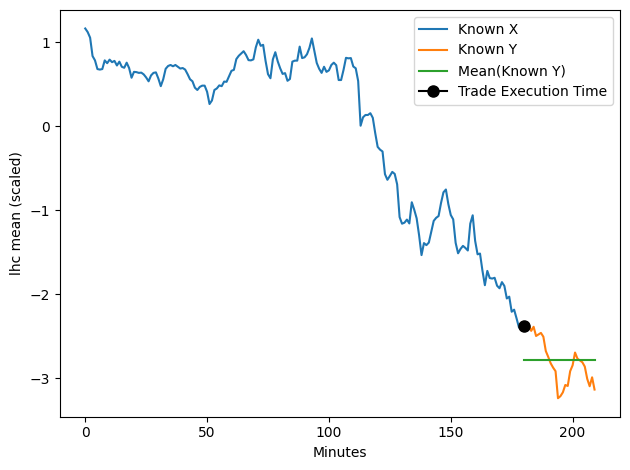

In [4]:
ts.plot_it(index_panel = 2000)

In [5]:
model_result = ModelResult(model_training_output_directory, training_run, ts)
model_result.fit()

2025-03-21 17:50:04.208692: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6335 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:65:00.0, compute capability: 7.5
2025-03-21 17:50:04.337793: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


388/388 [==============================] - 100s 255ms/step


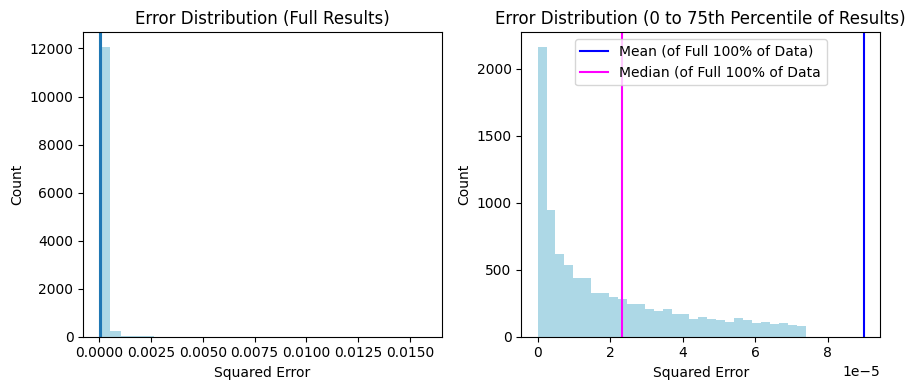

In [6]:
model_result.plot_error_histogram()

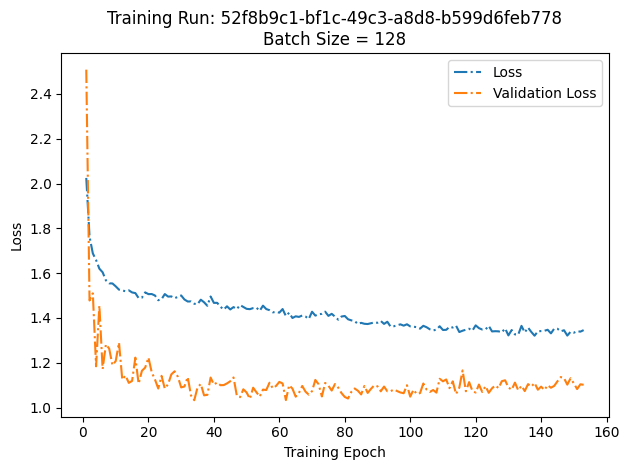

In [7]:
model_result.plot_basic_loss()

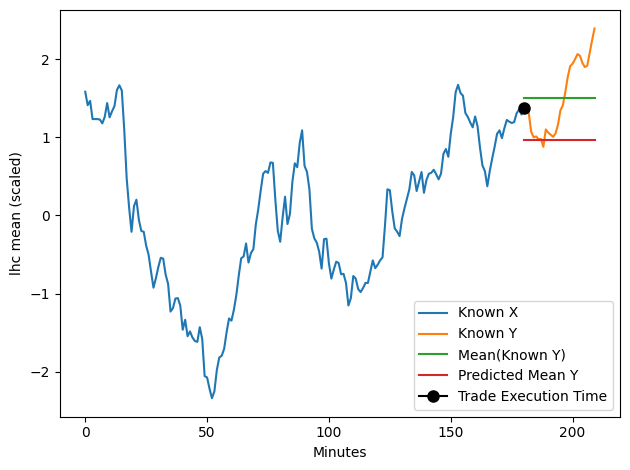

In [8]:
model_result.plot_a_prediction(index_panel = 0)

In [9]:
model_result.error_metric

1.1155455030465926

In [10]:
def summary(model_result):
    mr = model_result
    
    ts = mr.train_val_test_data

    mr.summary_dict = {
        'training_run' : mr.training_run,
        'error_metric' : mr.error_metric,

        'config_source_data' : ts.config,
    }

In [11]:
summary(model_result)
pp.pprint(model_result.summary_dict)

NameError: name 'pp' is not defined

In [ ]:
from config_lstm_regressor import config as config_lstm_regressor
pp.pprint(config_lstm_regressor)